Note: Your generator is NOT thread-safe.Keras requires a thread-safe generator when`use_multiprocessing=False, workers > 1`

    Improvement:
    1) Spectrogram (nperseg, noverlap, reshape)
    2) Insert background noise randomly (data augmentation)
    3) Develop a better data generator that is able to shuffle, handle the last batch
    4) Try different model architecture

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path
import time
from scipy.io import wavfile
from scipy import signal

# df_train

In [2]:
def get_data(path):
    ''' Returns dataframe with columns: 'path', 'word'.'''
    datadir = Path(path)
    files = [(str(f), f.parts[-2]) for f in datadir.glob('**/*.wav')]
    df = pd.DataFrame(files, columns=['path', 'word'])
    
    return df

In [3]:
df_train = get_data('./input/train/')

print('df_train.shape:', df_train.shape)
df_train.head()

df_train.shape: (64727, 2)


,path,word
0,input\train\audio\bed\00176480_nohash_0.wav,bed
1,input\train\audio\bed\004ae714_nohash_0.wav,bed
2,input\train\audio\bed\004ae714_nohash_1.wav,bed
3,input\train\audio\bed\00f0204f_nohash_0.wav,bed
4,input\train\audio\bed\00f0204f_nohash_1.wav,bed


In [4]:
print(len(df_train['word'].unique()))
df_train['word'].unique()

31


array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
       'two', 'up', 'wow', 'yes', 'zero', '_background_noise_'],
      dtype=object)

In [5]:
def prepare_data(df):
    '''Transform data into something more useful.'''
    train_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    words = df['word'].unique().tolist()
    silence = ['_background_noise_']
    unknown = [w for w in words if w not in silence + train_words]

    # there are only 6 silence files. Mark them as unknown too.
    df.loc[df['word'].isin(silence), 'word'] = 'unknown'
    df.loc[df['word'].isin(unknown), 'word'] = 'unknown'
    
    return df

In [6]:
df_train = prepare_data(df_train)

print('df_train.shape:', df_train.shape)
df_train.head()

df_train.shape: (64727, 2)


,path,word
0,input\train\audio\bed\00176480_nohash_0.wav,unknown
1,input\train\audio\bed\004ae714_nohash_0.wav,unknown
2,input\train\audio\bed\004ae714_nohash_1.wav,unknown
3,input\train\audio\bed\00f0204f_nohash_0.wav,unknown
4,input\train\audio\bed\00f0204f_nohash_1.wav,unknown


In [7]:
print(len(df_train['word'].unique()))
df_train['word'].unique()

11


array(['unknown', 'down', 'go', 'left', 'no', 'off', 'on', 'right',
       'stop', 'up', 'yes'], dtype=object)

# Create training and val set

In [8]:
from sklearn.preprocessing import LabelBinarizer

labelbinarizer = LabelBinarizer()
x = df_train['path']
y = labelbinarizer.fit_transform(df_train['word'])

In [9]:
print('y.shape:', y.shape)
y

y.shape: (64727, 11)


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [10]:
VALIDATION_SPLIT = 0.1

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  test_size = VALIDATION_SPLIT,
                                                  stratify = y)  #distribute evenly according to y

print('x_train.shape', x_train.shape)
print('x_val.shape', x_val.shape)
print('y_train.shape', y_train.shape)
print('y_val.shape', y_val.shape)

x_train.shape (58254,)
x_val.shape (6473,)
y_train.shape (58254, 11)
y_val.shape (6473, 11)


# batch_generator

In [12]:
def get_specgrams(paths, nsamples=16000):
    '''
    Given list of paths, return specgrams.
    '''
    
    # read the wav files
    wavs = [wavfile.read(path)[1] for path in paths]

    # zero pad the shorter samples and cut off the long ones.
    data = [] 
    for wav in wavs:
        if wav.size < 16000:
            d = np.pad(wav, (nsamples - wav.size, 0), mode='constant')
        else:
            d = wav[0:nsamples]
        data.append(d)

    # get the specgram
    specgrams = [signal.spectrogram(d, nperseg=256, noverlap=128)[2] for d in data]
    specgrams = [s.reshape(129, 124, -1) for s in specgrams]
    
    return specgrams

In [13]:
def batch_generator(X, y, batch_size=32):
    '''
    Return a random image from X, y
    '''
    
    while True:
        # choose batch_size random images / labels from the data
        idx = np.random.randint(0, X.shape[0], batch_size)
        paths = X[idx]
        labels = y[idx]
        
        specgrams = get_specgrams(paths)

        yield np.concatenate([specgrams]), labels

In [14]:
BATCH_SIZE = 16

In [15]:
train_datagen = batch_generator(x_train.values, y_train, batch_size=BATCH_SIZE)
val_datagen = batch_generator(x_val.values, y_val, batch_size=BATCH_SIZE)

In [16]:
# train_datagen testing
i=1
for x_batch, y_batch in train_datagen:
    if i > 5:
        break
    print(x_batch.shape)
    print(y_batch.shape)
    i+=1

(16, 129, 124, 1)
(16, 11)
(16, 129, 124, 1)
(16, 11)
(16, 129, 124, 1)
(16, 11)
(16, 129, 124, 1)
(16, 11)
(16, 129, 124, 1)
(16, 11)


# Model

In [17]:
import keras
from keras import backend as K
import tensorflow as tf

from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Input, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [18]:
# Metric: F1

def f1(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [19]:
def create_model(input_shape):
    '''Create a keras model.'''
    inputs = Input(shape=input_shape)

    model = BatchNormalization()(inputs)
    model = Conv2D(16, (3, 3), activation='elu')(model)
    model = Dropout(0.25)(model)
    model = MaxPooling2D((2, 2))(model)

    model = Flatten()(model)
    model = Dense(32, activation='elu')(model)
    model = Dropout(0.25)(model)
    
    # 11 because background noise has been taken out
    outputs = Dense(11, activation='sigmoid')(model)
    
    model = Model(inputs, outputs)
    
    model.summary()
    
    return model

In [20]:
INPUT_SHAPE = (129, 124, 1)

In [21]:
%%time

keras.backend.clear_session()

# Create model
model = create_model(input_shape = INPUT_SHAPE)

# Load weights
# model.load_weights('./model/speech_valloss_0.1660.h5')

# Compile model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(lr=1e-03),
    metrics = ['acc', f1])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 129, 124, 1)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 129, 124, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 122, 16)      160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 122, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 61, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61488)             0         
____________________

In [22]:
# Callbacks

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

callbacks = [
             EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, cooldown=1, min_lr=1e-6),
             ModelCheckpoint(filepath='./model/speech_valloss.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=False),
             TensorBoard(log_dir='./logs/{}'.format(time.time()), batch_size=BATCH_SIZE)
            ]

In [24]:
EPOCHS = 5
train_steps = x_train.shape[0]//BATCH_SIZE
val_steps = x_val.shape[0]//BATCH_SIZE

print('train_steps:', train_steps)
print('val_steps:', val_steps)

train_steps: 3640
val_steps: 404


In [25]:
%%time
# Train the model

history = model.fit_generator(
                train_datagen,
                steps_per_epoch = train_steps,
                epochs = EPOCHS,
                validation_data = val_datagen,
                validation_steps = val_steps,
                callbacks = callbacks,
                #workers=3,  #generator is not thread-safe
                max_queue_size=10,
                )



Epoch 1/5
 756/3640 [=====>........................] - ETA: 53s - loss: 1.6225 - acc: 0.6169 - f1: 0.120

D:\Anaconda3\envs\tensorflow\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


3640/3640 [==============================] - 67s 19ms/step - loss: 1.3905 - acc: 0.6340 - f1: 0.1428 - val_loss: 1.3361 - val_acc: 0.6351 - val_f1: 0.1611
Epoch 2/5
3640/3640 [==============================] - 65s 18ms/step - loss: 1.2191 - acc: 0.6400 - f1: 0.1733 - val_loss: 1.4258 - val_acc: 0.6440 - val_f1: 0.1627
Epoch 3/5
3640/3640 [==============================] - 64s 18ms/step - loss: 1.1634 - acc: 0.6408 - f1: 0.1881 - val_loss: 1.3892 - val_acc: 0.6334 - val_f1: 0.1728
Epoch 4/5
3640/3640 [==============================] - 67s 18ms/step - loss: 1.0978 - acc: 0.6404 - f1: 0.2049 - val_loss: 1.3189 - val_acc: 0.6374 - val_f1: 0.1891
Epoch 5/5
3640/3640 [==============================] - 66s 18ms/step - loss: 1.0659 - acc: 0.6432 - f1: 0.2128 - val_loss: 1.2381 - val_acc: 0.6545 - val_f1: 0.1988
Wall time: 5min 30s


In [24]:
# Save model
# model.save('./model/speech_valloss_.h5')

In [26]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_f1', 'loss', 'acc', 'f1', 'lr'])


# Model Evaluation

## 1) Plot learning rate, loss, acc

In [27]:
def show_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    ax[0].set_title('learning rate')
    ax[0].plot(history.epoch, history.history["lr"], label="lr")

    ax[1].set_title('loss')
    ax[1].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[1].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    
    ax[3].set_title('f1')
    ax[3].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[3].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

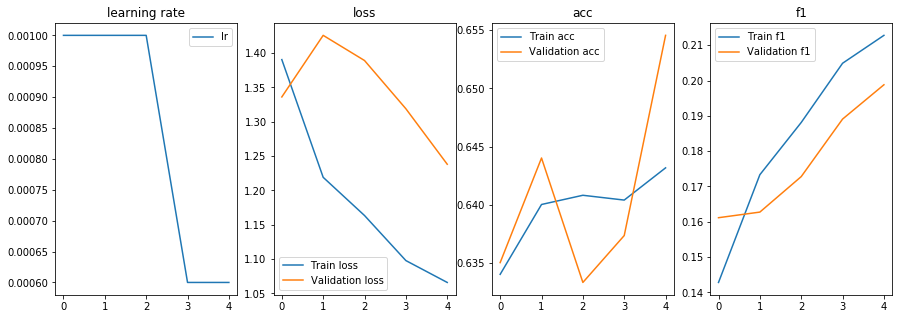

In [28]:
show_history(history)

## 2) Loss, acc, f1

In [29]:
%%time

# score = model.evaluate(x_val, y_val)
score = model.evaluate_generator(val_datagen, 
                                 steps = val_steps
                                )
print("loss:", score[0])
print("metric (acc):", score[1])
print("metric (f1):", score[2])

loss: 1.2937257059729925
metric (acc): 0.645884900990099
metric (f1): 0.20432150765958398
Wall time: 6.19 s


## 3) Confusion Matrix

There is a problem: val_datagen has shuffle index. So the confusion matrix give wrong result.

Solution: make a better data generator

In [30]:
%%time

# y_val_pred = model.predict_classes(x_val)
y_val_pred_prob = model.predict_generator(val_datagen, 
                                          steps = val_steps
                                         )

Wall time: 6.23 s


In [31]:
print('y_val_pred_prob.shape:', y_val_pred_prob.shape)
y_val_pred_prob

y_val_pred_prob.shape: (6464, 11)


array([[2.1313906e-02, 1.3012719e-01, 9.9718571e-05, ..., 9.9979341e-01,
        9.9301338e-05, 3.9935112e-06],
       [2.3029149e-03, 9.0450048e-05, 6.8455935e-05, ..., 1.0000000e+00,
        3.6050975e-03, 0.0000000e+00],
       [2.5252491e-02, 1.9665241e-02, 1.4295638e-01, ..., 9.9992567e-01,
        3.4412146e-03, 9.8805994e-02],
       ...,
       [9.3659210e-01, 5.9038401e-05, 5.5432320e-06, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.6531969e-01, 1.2189150e-05, 1.7881393e-07, ..., 9.9999917e-01,
        2.9802322e-08, 0.0000000e+00],
       [2.9802322e-07, 8.3685219e-03, 1.3411045e-06, ..., 1.0000000e+00,
        0.0000000e+00, 1.0132790e-06]], dtype=float32)

In [32]:
y_val_pred_prob.max(axis=1,keepdims=1)

array([[0.9997934],
       [1.       ],
       [0.9999257],
       ...,
       [1.       ],
       [0.9999996],
       [1.       ]], dtype=float32)

In [33]:
y_val_pred = (y_val_pred_prob == y_val_pred_prob.max(axis=1,keepdims=1)).astype(int)
y_val_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [34]:
import itertools
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred, labels):
    instcount = y_true.shape[0]
    n_classes = len(labels)
    fp = ((y_true - y_pred) < 0).sum(axis = 0)
    fn = ((y_true - y_pred) > 0).sum(axis = 0)
    tp = (y_true*y_pred).sum(axis = 0)
    tn = ((y_true==0)*(y_pred==0)).sum(axis = 0)
    mtx = np.vstack([tp/(tp + fn), fn/(tp + fn), tn/(tn + fp), fp/(tn + fp)]).T
    plt.figure(num=None, figsize=(5, 15), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtx, interpolation='nearest',cmap='Blues')
    plt.title("Confusion matrix")
    tick_marks = np.arange(n_classes)
    plt.xticks(np.arange(4), ['1 - 1','1 - 0','0 - 0','0 - 1'])
    plt.yticks(tick_marks, labels)
    for i, j in itertools.product(range(n_classes), range(4)):
        plt.text(j, i, round(mtx[i][j],2), horizontalalignment="center")

    plt.ylabel('labels')
    plt.xlabel('True-Predicted')
    plt.show()

In [35]:
labels = df_train['word'].unique().tolist()
labels

['unknown',
 'down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'up',
 'yes']

In [36]:
y_val.shape

(6473, 11)

In [37]:
y_val_pred.shape

(6464, 11)

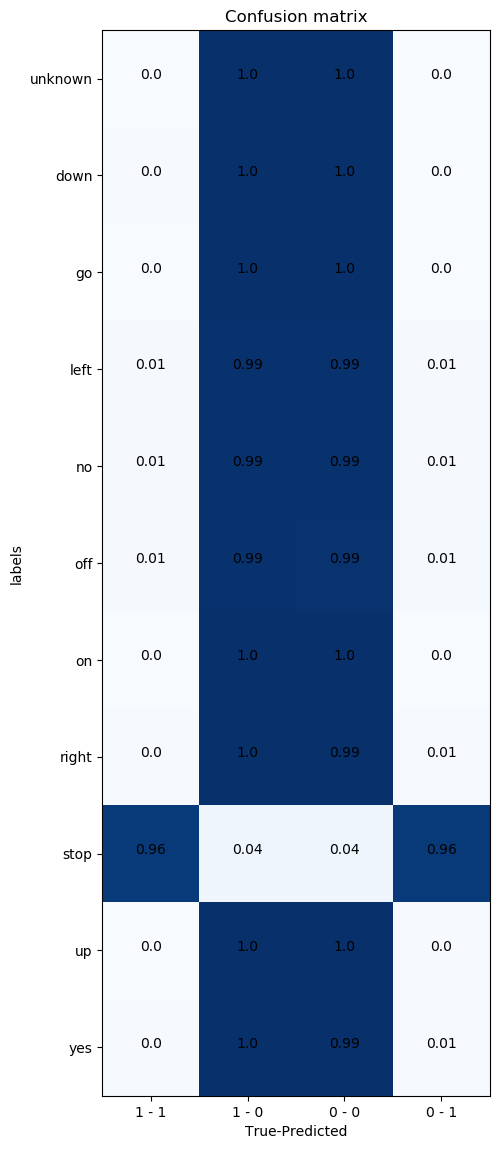

In [38]:
confusion_matrix(y_val[: y_val_pred.shape[0]],   # skip last batch (6473-6464)
                 y_val_pred,
                 labels)

# 4) Miss-Classification table

In [39]:
def miss_classification(y_true, y_pred, classes, percent=False, multi_label=True):
    '''
    Params:
        y_true, y_pred : binary numpy array
        classes : list of names classes
        percent : display persent of miss classification
        multi_label : target can have multy labels
    '''

    n_classes = len(classes)
    fp = ((y_true - y_pred) < 0).astype('int')
    fn = ((y_true - y_pred) > 0).astype('int')
    mtc = (fn.T @ fp)
    if multi_label:
        mtc = np.hstack([mtc, (fp.sum(axis = 0) - mtc.sum(axis = 0)).clip(0)[:,None]])
        classes.append('As extra class')
    if percent:
        mtc = (mtc / mtc.sum(axis = 1)[:,None])
        mtc = np.nan_to_num(mtc).clip(0,1) * 100
        
    plt.figure(num=None, figsize=(10.5, 10.5), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtc, interpolation='nearest',cmap='Blues')
    plt.title("Miss-Classification table")

    plt.xticks(np.arange(mtc.shape[1]), classes, rotation=90)
    plt.yticks(np.arange(mtc.shape[0]), classes, rotation=0)
    
    for i in range(mtc.shape[0]):
        for j in range(mtc.shape[1]):
            plt.text(j, i, int(mtc[i][j]), horizontalalignment="center")
    plt.ylabel('True labels')
    plt.xlabel('Predicted Miss labeled')
    plt.show()

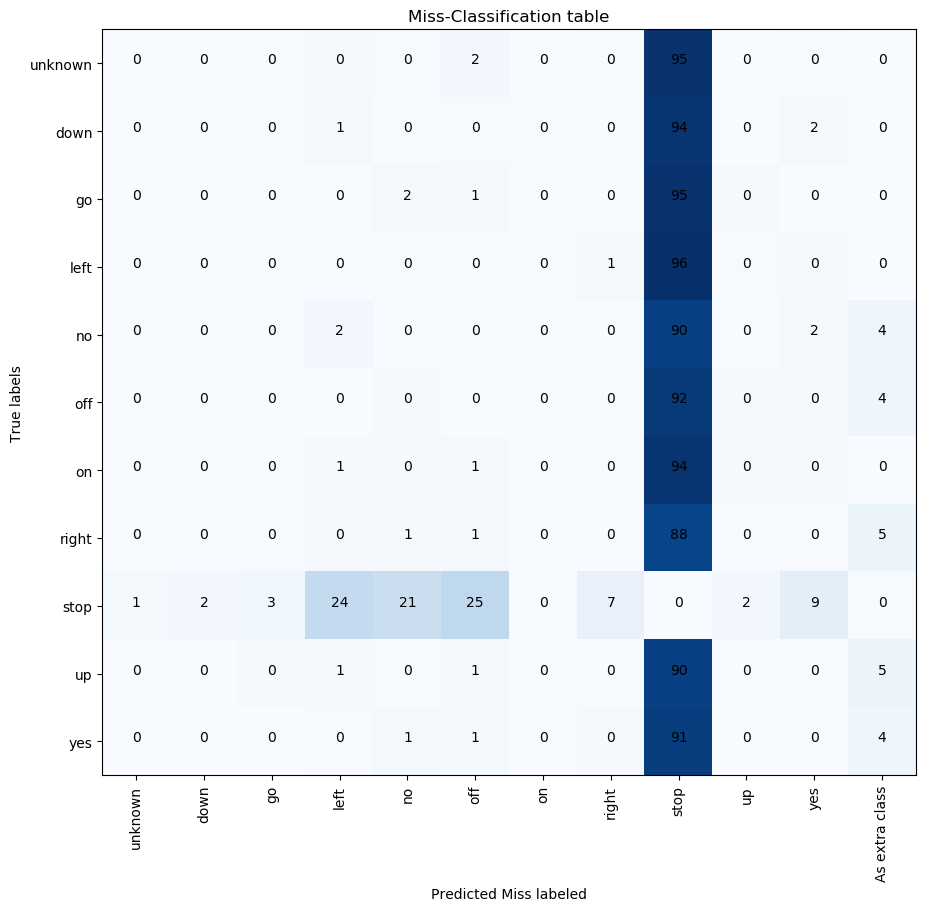

In [40]:
miss_classification(y_val[: y_val_pred.shape[0]],   # skip last batch (6473-6464)
                    y_val_pred,
                    labels,
                    percent=True)

# Prediction

In [29]:
df_test = get_data('./input/test/')

print('df_test.shape:', df_test.shape)
df_test.head()

df_test.shape: (158538, 2)


,path,word
0,input\test\audio\clip_000044442.wav,audio
1,input\test\audio\clip_0000adecb.wav,audio
2,input\test\audio\clip_0000d4322.wav,audio
3,input\test\audio\clip_0000fb6fe.wav,audio
4,input\test\audio\clip_0001d1559.wav,audio


In [30]:
df_test = prepare_data(df_test)

print('df_test.shape:', df_test.shape)
df_test.head()

df_test.shape: (158538, 2)


,path,word
0,input\test\audio\clip_000044442.wav,unknown
1,input\test\audio\clip_0000adecb.wav,unknown
2,input\test\audio\clip_0000d4322.wav,unknown
3,input\test\audio\clip_0000fb6fe.wav,unknown
4,input\test\audio\clip_0001d1559.wav,unknown


In [33]:
predictions = []
paths = df_test['path']

for path in paths:
    specgram = get_specgrams([path])
    pred = model.predict(np.array(specgram))
    predictions.append(pred)
    
predictions_prob = np.array(predictions).squeeze()

In [47]:
print('predictions_prob.shape', predictions_prob.shape)
predictions_prob

predictions_prob.shape (158538, 11)


array([[4.3720007e-05, 2.1310151e-03, 5.0836802e-04, ..., 2.4077071e-02,
        2.7102394e-07, 5.3043605e-05],
       [1.0824615e-01, 6.0948730e-04, 4.8179328e-03, ..., 7.9814839e-01,
        8.6647095e-05, 1.1532393e-03],
       [9.5993280e-05, 6.3309371e-03, 3.5762787e-07, ..., 3.0727836e-01,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.2100928e-03, 4.7136515e-02, 1.2188911e-02, ..., 3.7771374e-01,
        2.6015504e-03, 4.6012220e-03],
       [9.6878111e-03, 1.2132347e-02, 2.7947158e-02, ..., 6.5050977e-01,
        3.9509282e-02, 3.3101704e-02],
       [9.2208385e-05, 4.7900975e-03, 1.0907650e-05, ..., 5.5271864e-01,
        0.0000000e+00, 3.5939802e-08]], dtype=float32)

In [48]:
predictions_prob.max(axis=1,keepdims=1)

array([[0.64660734],
       [0.7981484 ],
       [0.30727836],
       ...,
       [0.37771374],
       [0.6505098 ],
       [0.55271864]], dtype=float32)

In [49]:
predictions = (predictions_prob == predictions_prob.max(axis=1,keepdims=1)).astype(int)
predictions

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [50]:
predictions_label = labelbinarizer.inverse_transform(predictions)
print('predictions_label.shape:', predictions_label.shape)
predictions_label

predictions_label.shape: (158538,)


array(['no', 'unknown', 'unknown', ..., 'unknown', 'unknown', 'unknown'],
      dtype='<U7')

In [51]:
df_test['labels'] = predictions_label

In [52]:
df_test['path'] = df_test['path'].apply(lambda x: str(x).split("\\")[-1])

In [53]:
df_test.head(10)

,path,word,labels
0,clip_000044442.wav,unknown,no
1,clip_0000adecb.wav,unknown,unknown
2,clip_0000d4322.wav,unknown,unknown
3,clip_0000fb6fe.wav,unknown,unknown
4,clip_0001d1559.wav,unknown,unknown
5,clip_0002256ed.wav,unknown,unknown
6,clip_0002a4a1f.wav,unknown,on
7,clip_0002d9b83.wav,unknown,unknown
8,clip_000373a5b.wav,unknown,unknown
9,clip_0003c7122.wav,unknown,unknown


In [54]:
submission = pd.DataFrame({'fname': df_test['path'], 'label': df_test['labels']})
submission.head(10)

,fname,label
0,clip_000044442.wav,no
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,unknown
4,clip_0001d1559.wav,unknown
5,clip_0002256ed.wav,unknown
6,clip_0002a4a1f.wav,on
7,clip_0002d9b83.wav,unknown
8,clip_000373a5b.wav,unknown
9,clip_0003c7122.wav,unknown


In [55]:
submission.to_csv('./output/submission.csv', index=False)